In [1]:
import pandas as pd

titanic = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt')

In [3]:
titanic.head()

,row.names,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,sex
0,1,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,2,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,3,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,(135),male
3,4,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,5,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male


分离数据特征与预测目标

In [18]:
y = titanic['survived']
X = titanic.drop(['row.names','name','survived'],axis=1)

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 8 columns):
pclass       1313 non-null object
age          633 non-null float64
embarked     821 non-null object
home.dest    754 non-null object
room         77 non-null object
ticket       69 non-null object
boat         347 non-null object
sex          1313 non-null object
dtypes: float64(1), object(7)
memory usage: 82.1+ KB


In [20]:
# 对缺失的数据进行填充
X['age'].fillna(X['age'].mean(),inplace=True)

In [21]:
X.fillna('UNKNOWN',inplace=True)

In [43]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 33)

+ **类别型的特征向量化**

In [44]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()

X_train = vec.fit_transform(X_train.to_dict(orient='record'))
X_test = vec.transform(X_test.to_dict(orient='record'))

+ 可以看到，向量化以后的特征增加非常快，这是因为标量型的特征可能的值很多。

In [52]:
len(vec.feature_names_)

474

+ 使用决策树

In [53]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
dt.score(X_test,y_test)

0.81762917933130697

+ 使用特征选择器

In [78]:
from sklearn import feature_selection
 
fs = feature_selection.SelectPercentile(feature_selection.chi2,percentile=20)
X_train_fs = fs.fit_transform(X_train,y_train)
print(X_train_fs.toarray().shape)
dt.fit(X_train_fs,y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs,y_test)

(984, 94)


0.82066869300911849

使用交叉验证的方法筛选特征

In [97]:
from sklearn.model_selection import cross_val_score

percentiles = list(range(1,100,2))

In [98]:
results = []

for i in percentiles:
    fs = feature_selection.SelectPercentile(feature_selection.chi2,percentile=i)
    X_train_fs = fs.fit_transform(X_train,y_train)
    scores = cross_val_score(dt,X_train_fs,y_train,cv=5)
    results = np.append(results,scores.mean())

In [99]:
results

array([ 0.85063904,  0.85673057,  0.87501546,  0.88622964,  0.86485261,
        0.875067  ,  0.875067  ,  0.86894455,  0.86488353,  0.86491445,
        0.86996496,  0.86387343,  0.86592455,  0.86792414,  0.86387343,
        0.86690373,  0.86894455,  0.86488353,  0.86385281,  0.86284271,
        0.8608019 ,  0.86183261,  0.86893424,  0.86995465,  0.87097506,
        0.86693465,  0.86893424,  0.86894455,  0.86486291,  0.86996496,
        0.86589363,  0.86792414,  0.86692435,  0.86384251,  0.86792414,
        0.86994434,  0.86892393,  0.87201608,  0.86691404,  0.86692435,
        0.86590394,  0.86893424,  0.86690373,  0.86893424,  0.86284271,
        0.86487322,  0.86082251,  0.86285302,  0.86184292,  0.85675119])

In [108]:
opt = np.where(results == np.max(results))[0][0]

In [109]:
opt

3

In [110]:
percentiles[opt]

7

从图上也可以看出， 7 是最好的。

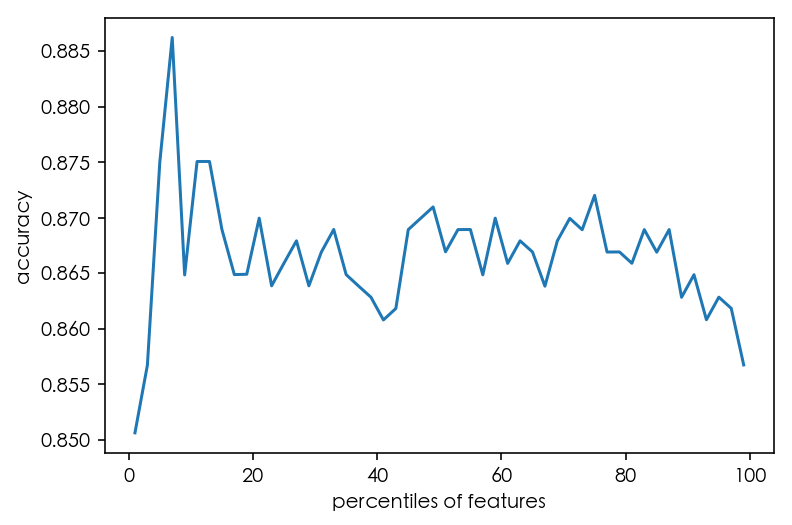

In [111]:
import matplotlib.pyplot as plt 

plt.plot(percentiles,results)
plt.xlabel('percentiles of features')
plt.ylabel('accuracy')
plt.show()

筛选完以后，用 7 在测试数据集上再跑一遍模型。

In [114]:
from sklearn import feature_selection

fs = feature_selection.SelectPercentile(feature_selection.chi2,percentile=7)
X_train_fs = fs.fit_transform(X_train,y_train)
dt.fit(X_train_fs,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [115]:
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs,y_test)

0.8571428571428571

线性回归与过拟合

In [1]:
X_train = [[6],[8],[10],[14],[18]]
y_train = [[7],[9],[13],[17.5],[18]]

In [2]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train,y_train)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
# 从 x 轴上从 0 到 25 均匀采样 100 个数据点

xx = np.linspace(0,26,100)
xx = xx.reshape(xx.shape[0],-1)

In [11]:
yy = regressor.predict(xx)

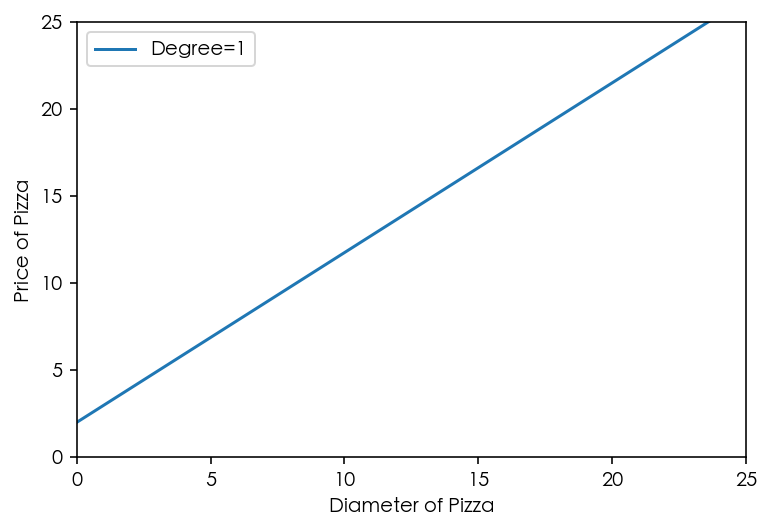

In [14]:
import matplotlib.pyplot as plt

plt1, = plt.plot(xx,yy,label='Degree=1')
plt.axis([0,25,0,25])
plt.xlabel('Diameter of Pizza')
plt.ylabel('Price of Pizza')
plt.legend(handles=[plt1])
plt.show()

In [15]:
regressor.score(X_train,y_train)

0.91000159642401024